# Step5 演習02 アンダーフィッティングとオーバーフィッティング
---

Step5ではアンダーフィッティングとオーバーフィッティングの見分け方と対策法を学習します。今回は線形回帰の例を用います。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- アンダーフィッティングとオーバーフィッティングの見分け方や対策方法を学ぶ。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [SciPy](https://docs.scipy.org/doc/) 数値解析ライブラリの基本パッケージの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from functools import partial #関数の一部の引数を固定するのに使う
import os
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## サンプルデータのロードとインデックスの生成

サンプルデータをロードします。線形関数ではフィッティングできないものの、さほど複雑ではない分布をしているデータが格納されています。

In [2]:
data = np.loadtxt("./dataStep5/dataStep5.csv", delimiter=",")
data_m, data_n = data.shape

各訓練例をシャッフルしてインデックスをつけておきます。扱う訓練例が少ないため、人為的に選んだインデックスを使います。

In [3]:
if os.path.isfile("./dataStep5/dataStep5_shuffle_idx.csv") == True:
    shuffle_idx = np.loadtxt("./dataStep5/dataStep5_shuffle_idx.csv", delimiter = ",", dtype=np.uint8)

else:
    shuffle_idx =  np.random.permutation(data_m)
    np.savetxt("./dataStep5/dataStep5_shuffle_idx.csv", shuffle_idx, delimiter=",", fmt = "%d")

上のセルを実行したことによりデータセットを "data" に格納しました。下のセルを実行して、dataのshapeを確認しましょう。

In [4]:
data.shape

(200, 2)

(200,2)と表示されたはずです。今回使うデータセットは200行2列の行列がdataに格納されています。

## データのセット

** 訓練集合(X, y) **,**  交差検証集合(Xval, yval) **, ** テスト集合(Xtest, ytest) **としてそれぞれ6:2:2程度の分量に`data`を分割しておきます。視覚的に状況を分かりやすくするため、訓練例は30個程度に絞ります。

今回はインデックスを再現できるように手動で分割しますが、実践の場面でランダム化したうえ分割する場合、`sklearn.model_selection.train_test_split()`関数を使うと便利でしょう。

参考：[scikit-learnチュートリアル sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [5]:
X = data[shuffle_idx[:30],0]
y = data[shuffle_idx[:30],1]
Xcv = data[shuffle_idx[30:40],0]
ycv = data[shuffle_idx[30:40],1]
Xtest = data[shuffle_idx[40:50],0]
ytest = data[shuffle_idx[40:50],1]

In [6]:
print("Xの個数:", X.shape[0])
print("Xcvの個数:", Xcv.shape[0])
print("Xtestの個数:", Xtest.shape[0])

Xの個数: 30
Xcvの個数: 10
Xtestの個数: 10


In [7]:
m = X.shape[0] #訓練例の数はm
m_cv = Xcv.shape[0] #交差検証例の数はm_val

In [8]:
print("訓練例の数:", m)
print("交差検証例の数:",  m_cv)

訓練例の数: 30
交差検証例の数: 10


## データのプロット

**【課題１】** 訓練例と交差検証例をプロットする関数`plotData(X, y, Xcv, ycv)`を書きましょう。訓練例と交差検証例は区別するために色を指定しましょう。（Step5_01の課題１と同じ課題です。）

参考：[matplotlob 公式チュートリアル matplotlib.pyplot.scatter](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)

In [9]:
#Coursemale-02 Step5 QuestionNumber1 80169b532acc39bd775f6da53633c5ed
def plotData(X, y, Xcv, ycv):
###############ここを穴埋めしてください###############
    plt.scatter(X, y, c="b", label=u'訓練データ')
    plt.scatter(Xcv, ycv, c="r", label=u'交差検証データ')
    plt.xlim([-5,5])
    plt.ylim([-1,5])
    plt.legend(loc="upper left")
    plt.draw()  
   
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [10]:
%%bash
./validation_client.py male-02 5 1 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



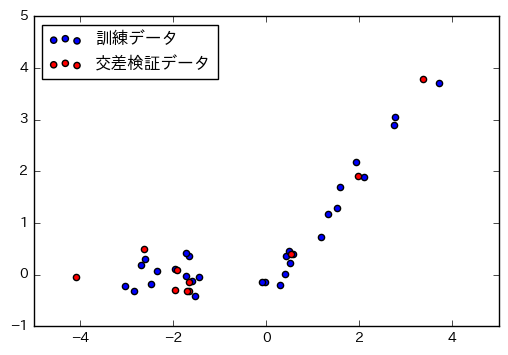

In [11]:
plotData(X, y, Xcv, ycv)

## 正則化線形回帰の目的関数

正則化された線形回帰の目的関数を実装します。その前に、パラメータ$\theta$を初期化し、正則化パラメータラムダは１にします。

In [12]:
theta = np.ones(2) # thetaは1-dim
lmd = 1

**【課題２】** 正則化された線形回帰の目的関数`linearRegCostFunction(theta, X, y, lmd)`を実装しましょう。`XwithBias`は`X`にバイアスを付加したものとします。（Step5_01の課題２と同じ課題です。）

In [13]:
#Coursemale-02 Step5 QuestionNumber2 0b69f3cd01c23b78867e8f34b3b9d5a2
def linearRegCostFunction(theta, XwithBias, y, lmd):
###############ここを穴埋めしてください###############
    m = y.size
    J = ((np.dot(XwithBias, theta.T) - y)**2).sum() / (2*m) + (lmd / (2*m)) * (theta[1:]**2).sum()
    return J
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [14]:
%%bash
./validation_client.py male-02 5 2 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



念のためちゃんと走るか確認してみましょう。（正しい答えかどうかは分からない）

In [15]:
J = linearRegCostFunction(theta, np.c_[np.ones([m,1]),X], y, lmd) # Xはバイアスつけた状態で渡す

In [16]:
print("thetaが[1, 1]のときのコストJは", J)

thetaが[1, 1]のときのコストJは 0.7270372836123554


## 正則化線形回帰の目的関数の勾配(gradient)

**【課題３】** 正則化された線形回帰の目的関数の勾配`linearRegGrad(theta, XwithBias, y, lmd)`を実装しましょう。`XwithBias`は`X`にバイアスを付加したものとします。（Step5_01の課題３と同じ課題です。）

In [17]:
#Coursemale-02 Step5 QuestionNumber3 dbee1c36b59a507128480539e13a164d
def linearRegGrad(theta, XwithBias, y, lmd):
###############ここを穴埋めしてください###############
    m = y.size
    grad = XwithBias.T.dot(np.dot(XwithBias, theta) - y) / m + (lmd / m) * np.r_[0, theta[1:]] 
    return grad
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [19]:
%%bash
./validation_client.py male-02 5 3 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



念のためちゃんと走るか確認してみましょう。（正しい答えかどうかは分からない）

In [20]:
grad = linearRegGrad(theta, np.c_[np.ones([m,1]),X], y, lmd) # Xはバイアスつけた状態で渡す

In [21]:
print("thetaが[1, 1]のときの目的関数のgradは", grad)

thetaが[1, 1]のときの目的関数のgradは [0.13541991 1.92030114]


## 線形回帰の学習

**【課題４】** 線形回帰モデルをつかって学習する関数`trainLinearReg(X, y, lmd)`を実装しましょう。`XwithBias`は`X`にバイアスを付加したものとします。返値はパラメータの配列`theta`になるようにしてください。（Step5_01の課題４と同じ課題です。）

In [22]:
#Coursemale-02 Step5 QuestionNumber4 e004d9191eca1eddf8ce00f496038bc6
def trainLinearReg(XwithBias, y, lmd):
###############ここを穴埋めしてください###############
    m, n = XwithBias.shape # Xはここではバイアス項を付け加えているので2-dim


    # thetaの初期化
    #initial_thetaは1-dim
    initial_theta = np.zeros(n)

    # 最適化する変数以外は固定 
    cost_fixed = partial(linearRegCostFunction, XwithBias=XwithBias, y=y, lmd=lmd) #functools
    grad_fixed = partial(linearRegGrad, XwithBias=XwithBias, y=y, lmd=lmd) #functools

    # 最適化
    res = scopt.minimize(cost_fixed, initial_theta, method='BFGS', jac=grad_fixed)

    return res.x
#######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [24]:
%%bash
./validation_client.py male-02 5 4 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## 多項式回帰分析のための特徴を準備（Feature Normalize も）

多項式で特徴を増やし、多項式回帰を行いましょう。このとき、新しく作った各特徴のレンジが大きく違うので、Feature Normalizeが必須であることを思い出しましょう。

※課題１〜４までStep5_01と同じ課題であったので同じ課題番号を割り当てました。次の課題６から新たな課題です。課題５が飛んでいるわけではありません。

**【課題６】** 多項式で特徴を増やす関数`polyFeatures(X, p)`を実装しましょう。なお、`X`はバイアスを含みません。`p`は次数を指します。返値は各訓練例に対する（多項式で増やした）新しい特徴であり、shapeが`(m, p)`の配列となります。

In [25]:
#Coursemale-02 Step5 QuestionNumber6 f4143360d78b3f059c5a57ea21e0db2b
def polyFeatures(X, p):
    m, = X.shape # Xは1-dim。mの後のカンマ必須
    X_poly = np.empty((m, p))

###############ここを穴埋めしてください###############
    for i in range(p):
        X_poly[:,i] = X**(i+1)
######################################################

    return X_poly

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [26]:
%%bash
./validation_client.py male-02 5 6 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



---
**【課題６別解】（参考）**

この課題については参考として、内包表記を用いた解答例を載せておきます。

In [27]:
def polyFeatures(X, p):
    return np.array([X**(i+1) for i in range(p)]).T

---

**【課題７】** Feature Normalizeを行う関数`featureNormalize(X)`を実装しましょう。`X`はバイアスを含んでいません。返値はFeature Normalize済みの`X`である`X_norm`、 平均`mu`、標準偏差`sigma`の三つで、`return [X_norm, mu, sigma]`といった具合に返して下さい。

In [28]:
#Coursemale-02 Step5 QuestionNumber7 150531b3eb479795993d4e1abaa8ab6b
def featureNormalize(X):
###############ここを穴埋めしてください###############
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_norm = ( X - mu ) / sigma

    return [X_norm, mu, sigma]
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [29]:
%%bash
./validation_client.py male-02 5 7 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## 多項式回帰

特徴を5次まで増やしてオーバーフィッティングしやすい仮説にしておきます。

In [30]:
p = 5

多項式で特徴を増やします。

In [31]:
X_poly = polyFeatures(X, p)

Feature Normalizeします。

In [32]:
X_poly_norm, mu, sigma = featureNormalize(X_poly)

交差検証例もテスト例も今行ったFeature Scalingに合わせます。

In [33]:
X_poly_cv = polyFeatures(Xcv, p)
X_poly_cv_norm = (X_poly_cv - mu) / sigma #ブロードキャスト

In [34]:
X_poly_test = polyFeatures(Xtest, p)
X_poly_test_norm = (X_poly_test - mu) / sigma #ブロードキャスト

各々バイアスを付加します。

In [35]:
m_cv = Xcv.shape[0]
m_test = Xtest.shape[0]

X_poly_normWithBias = np.c_[np.ones([m,1]),X_poly_norm]
X_poly_cv_normWithBias = np.c_[np.ones([m_cv,1]),X_poly_cv_norm]
X_poly_test_normWithBias = np.c_[np.ones([m_test,1]),X_poly_test_norm]

ノーマライズされた訓練例（バイアス込み）を一つ見ておきましょう。

In [36]:
print("ノーマライズされた訓練例1: ", X_poly_normWithBias[0,:])

ノーマライズされた訓練例1:  [1.         1.55598247 1.16484881 1.49407642 0.83154722 0.97952962]


## 多項式回帰の学習曲線

多項式回帰の学習曲線をプロットします。正則化なしとします。(lmd = 0)

In [37]:
lmd = 0

In [38]:
theta = trainLinearReg(X_poly_normWithBias, y, lmd)

In [39]:
def plotFit(X, y, Xcv, ycv, theta, mu, sigma, p):
# pは多項式の次数
    #課題１で実装してもらった関数です
    plotData(X, y, Xcv, ycv)
    
    #このセル内で直前にプロットしたものに上書きしていきます
    plt.hold(True)
    
    min_x = X.min()
    max_x = X.max()
    #左右に少しはみ出るくらいにプロットしておく
    x = np.arange(min_x - 15, max_x + 25, 0.05)

    #そのxを多項式に
    x_poly_norm = ( polyFeatures(x, p) - mu ) / sigma #ブロードキャスト

    m_x_poly_norm, n_x_poly_norm = x_poly_norm.shape #x_polyは2-dim

    #1をズラッと並べる
    x_poly_normWithBias = np.c_[np.ones([m_x_poly_norm,1]),x_poly_norm]

    plt.plot(x, x_poly_normWithBias.dot(theta), label=u'多項式回帰 p=%d'%p)

    #念のため、グラフの端をもう一度指定しておきます。
    plt.xlim([-5,5])
    plt.ylim([-1,5])
    
    #凡例を入れます。
    plt.legend(loc="upper left")

    plt.show()

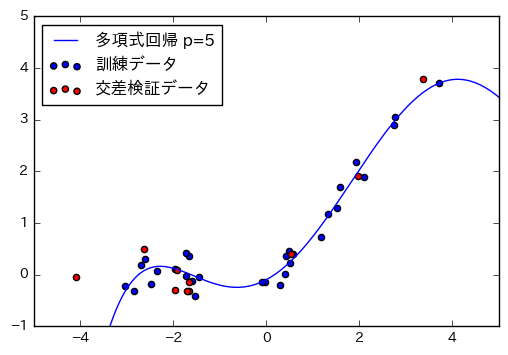

In [40]:
plotFit(X, y, Xcv, ycv, theta, mu, sigma, p)

In [41]:
def learningCurve(XwithBias, y, XcvWithBias, ycv, lmd):
    theta = np.array([trainLinearReg(XwithBias[:i+1], y[:i+1], lmd) for i in range(XwithBias.shape[0])])
    return np.array([[((XwithBias[:i+1].dot(theta[i])-y[:i+1])**2).sum() / (2*(i+1)), \
                     ((XcvWithBias.dot(theta[i])-ycv)**2).sum() / (2*XcvWithBias.shape[0])] for i in range(XwithBias.shape[0])]).T

In [42]:
def plotLearningCurve(error_train, error_cv):
    plt.plot(range(1,m+1), error_train, label=u"訓練集合")
    plt.plot(range(1,m+1), error_cv, label=u"交差検証集合")
    plt.legend(loc="best")
    plt.title(u"線形回帰の学習曲線")
    plt.xlabel(u"訓練例の数")
    plt.ylabel(u"誤差")
    plt.ylim([0, 0.4])
    plt.draw()

In [43]:
# XとXvalはバイアスつけた状態で渡す
error_train, error_cv = learningCurve(X_poly_normWithBias, y, X_poly_cv_normWithBias, ycv, lmd)

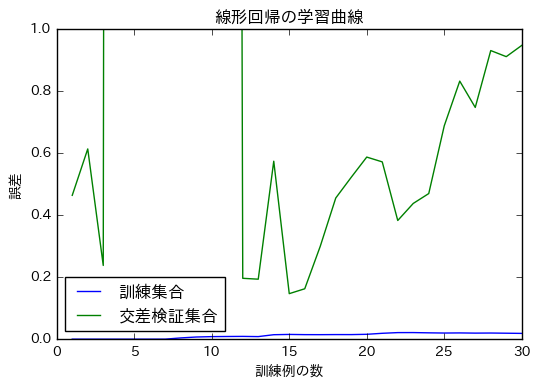

In [44]:
plotLearningCurve(error_train, error_cv)
plt.ylim([0,1])
plt.show()

訓練集合に対する誤差はかなり低いですが、交差検証集合に対する誤差はかなり暴れています。このグラフからオーバーフィッティングを予感して下さい。

念のため結果の数字を一覧すると、

In [45]:
print("訓練例\t学習誤差\t交差検証誤差")
for i in range(m):
    print(i+1, end="")
    print("\t", end="")
    print("%0.8f"%error_train[i], end="")
    print("\t", end="")
    print("%0.8f"%error_cv[i])

訓練例	学習誤差	交差検証誤差
1	0.00000000	0.46397628
2	0.00000000	0.61360695
3	0.00000000	0.23777040
4	0.00000000	32.84884624
5	0.00000000	3.35567621
6	0.00000000	2531.83909380
7	0.00005092	1371.61540932
8	0.00399558	2321.58720876
9	0.00691737	39.73344599
10	0.00817053	157.77464683
11	0.00859793	17.48928667
12	0.00891510	0.19630154
13	0.00825633	0.19344939
14	0.01432919	0.57403453
15	0.01524902	0.14680364
16	0.01459505	0.16253218
17	0.01449465	0.29951601
18	0.01477171	0.45525928
19	0.01471619	0.52223831
20	0.01565242	0.58735283
21	0.01889896	0.57183833
22	0.02113262	0.38279964
23	0.02123822	0.43783348
24	0.02038954	0.46968003
25	0.01973836	0.68816473
26	0.02010183	0.83237903
27	0.01947296	0.74751219
28	0.01976361	0.93093866
29	0.01917102	0.91131088
30	0.01857503	0.94756039


## 正則化パラメータlmdの選択

オーバーフィッティングを是正するため、正則化します。適切な正則化パラメータを選ぶために、横軸に正則化パラメータの値`lmd`、縦軸に誤差（訓練誤差と交差検証誤差）をプロットしたグラフを描画しましょう。

**【課題８】** チェックする正則化パラメータの値を収めた1次元配列`lmd_vec`のそれぞれの値に対して、訓練誤差`error_train`と交差検証誤差`error_cv`を出力する関数`validationCurve(X, y, Xcv, ycv, lmd_vec)`を自由に実装して下さい。返値は`[error_train, error_cv]`です。

In [49]:
#Coursemale-02 Step5 QuestionNumber8 767449dcf096606dc9ef96a3328548a1
def validationCurve(X, y, Xcv, ycv, lmd_vec):
    m, n = X.shape # ここのXは2-dim
    m_cv, n_cv = Xcv.shape

    error_train = np.empty(lmd_vec.size)
    error_cv = np.empty(lmd_vec.size)

###############ここを穴埋めしてください###############
    for i in range(lmd_vec.shape[0]):
        lmd = lmd_vec[i]
        theta = trainLinearReg(X, y, lmd)
        error_train[i] = ((X.dot(theta)-y)**2).sum()/(2*m)
        error_cv[i] = ((Xcv.dot(theta)-ycv)**2).sum()/(2*m_cv)
######################################################

    return [error_train, error_cv]

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [50]:
%%bash
./validation_client.py male-02 5 8 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



---
**【課題８別解】（参考）**

この課題については参考として、内包表記を用いた解答例を載せておきます。

In [51]:
def validationCurve(X, y, Xcv, ycv, lmd_vec):
    theta = np.array([trainLinearReg(X, y, lmd) for lmd in lmd_vec])
    return np.array([[((X.dot(theta_i)-y)**2).sum()/(2*X.shape[0]), \
                      ((Xcv.dot(theta_i)-ycv)**2).sum()/(2*Xcv.shape[0])] for theta_i in theta]).T

---

log scaleで等間隔になるように`lmd_vec`を作ります。

In [52]:
lmd_vec = np.logspace(-3, 2, 12)

作った関数`validationCurve(X, y, Xcv, ycv, lmd_vec)`を使って`error_train`, `error_cv`を得ます。

In [53]:
error_train, error_cv = validationCurve(X_poly_normWithBias, y, X_poly_cv_normWithBias, ycv, lmd_vec)

In [54]:
def plotLearningCurve(error_train, error_cv):
    plt.hold(True)
    
    plt.plot(lmd_vec, error_train, label=u"訓練集合")
    plt.plot(lmd_vec, error_cv, label=u"交差検証集合")
    
    plt.ylim([0,1])
    plt.xscale('log')
    plt.legend(loc="best")
    plt.title(u"線形回帰の学習曲線")
    plt.xlabel(u"正則化パラメータlmd")
    plt.ylabel(u"誤差")
    plt.show()

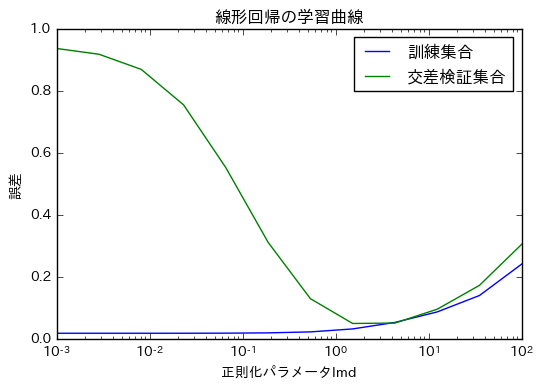

In [55]:
plotLearningCurve(error_train, error_cv)

In [56]:
print("正則化パラメータlmd\t学習誤差\t交差検証誤差")
for i in range(lmd_vec.size):
    print("\t", end="")
    print("%0.3f"%lmd_vec[i], end="")
    print("\t\t", end="")
    print("%0.8f"%error_train[i], end="")
    print("\t", end="")
    print("%0.8f"%error_cv[i])

正則化パラメータlmd	学習誤差	交差検証誤差
	0.001		0.01857520	0.93719469
	0.003		0.01857634	0.91863297
	0.008		0.01858486	0.86964613
	0.023		0.01863980	0.75540443
	0.066		0.01890422	0.55277313
	0.187		0.01984488	0.31192262
	0.534		0.02296991	0.13022453
	1.520		0.03258073	0.05014085
	4.329		0.05351394	0.05151346
	12.328		0.08743786	0.09617140
	35.112		0.14043174	0.17315555
	100.000		0.24188564	0.30576324


**【課題９】** グラフから適切だと思われる正則化パラメータの値を選択し、その`lmd`で学習させましょう。

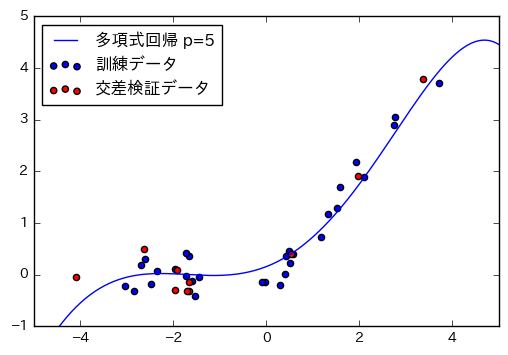

In [58]:
#Coursemale-02 Step5 QuestionNumber9 1d474381b39c9b2e84a62df3030c638d
###############ここを穴埋めしてください###############
lmd = 1.52
theta = trainLinearReg(X_poly_normWithBias, y, lmd)
plotFit(X, y, Xcv, ycv, theta, mu, sigma, p)
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [59]:
%%bash
./validation_client.py male-02 5 9 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



**【課題１０】** テスト集合を用いて交差検証集合を用いたモデル選択の結果を評価しましょう。

In [60]:
#Coursemale-02 Step5 QuestionNumber10 fa17b41302f8feb11c7e5cbf6eaad1cb
###############ここを穴埋めしてください###############
error_test = ((X_poly_test_normWithBias.dot(theta)-ytest)**2).sum() / (2*ytest.shape[0])
print("テスト誤差: %0.8f"%error_test)
######################################################

テスト誤差: 0.01147125


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [61]:
%%bash
./validation_client.py male-02 5 10 Step5_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## おわりに
訓練データや交差検証データを用いたモデルの選択の要領は以上のようなものです。どの程度の誤差まで許容できるのかによって、最後のテスト誤差を良しとするか否かは決まってきます。プロジェクトを始めるときは、何に利用するのか、どの程度の誤差まで許容できるのかということをまず念頭に置いておく必要があるわけです。